# 11.7 Moving Window Functions（移动窗口函数）

一种用于时间序列操作的重要用法，是使用滑窗（sliding windown）或呈指数降低的权重（exponentially decaying weights），来对时间序列进行统计值计算和其他一些函数计算。 这个对于消除噪声或有缺陷的数据是很有用的。这里我们称之为Moving Window Functions（移动窗口函数），不过其中也包括了不适用固定长度窗口的函数(functions without a fixed-length window)，比如指数加权移动平均数（exponentially weighted moving average）。和其他一些统计函数以后，这些函数也会自动无视缺失值。

我们先加载一些时间序列数据并按工作日频度进行重采样：

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
close_px_all = pd.read_csv('../examples/stock_px_2.csv',
                           parse_dates=True, index_col=0)

close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]

close_px = close_px.resample('B').ffill()

接下面介绍rolling操作符，效果和resample及groupby一样。通过window（用于表示周期的数字），这个操作符可以在Series或DataFrame上调用：

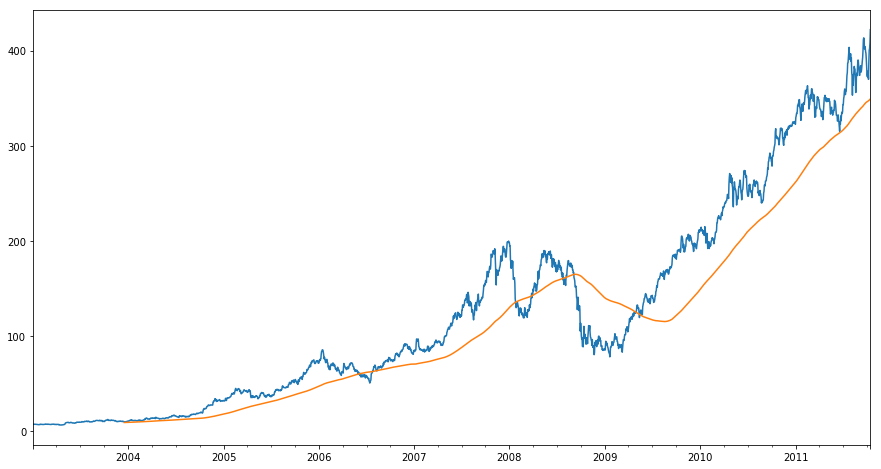

In [29]:
close_px.AAPL.plot()
close_px.AAPL.rolling(250).mean().plot(figsize=(15, 8))

这里的`rolling(250)`和groupby的效果一样，但并不是直接进行分组，而是创建了一个新的对象，并在一个有250天的滑窗上进行了分组。所以这里对于苹果的股价，我们得到了一个250天移动窗口平均值（moving window average）。

默认情况下滚动函数（rolling functions）需要窗口中所有的值为non-NA。如果有缺失值的话，我们会得到更少的windown周期：

In [6]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
appl_std250[5:12]

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15    0.077496
2003-01-16    0.074760
2003-01-17    0.112368
Freq: B, Name: AAPL, dtype: float64

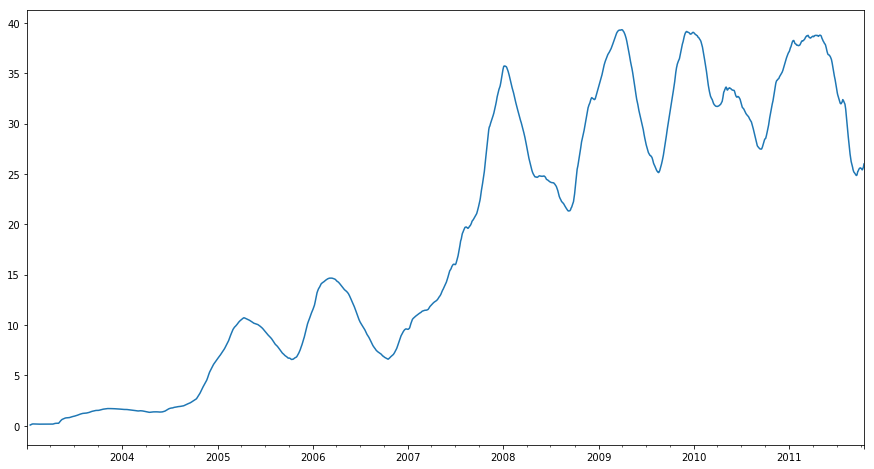

In [28]:
appl_std250.plot(figsize=(15, 8))

为了计算扩张窗口平均（expanding window mean），我们要使用expanding操作符，而不是用rolling。这个扩张平均的时间窗口是从时间序列开始的地方作为开始，窗口的大小会逐渐递增，直到包含整个序列。一个扩张窗口平均在时间序列上的计算像下面这样，我们拿apple_std250来做例子：

In [8]:
expanding_mean = appl_std250.expanding().mean()

在一个DataFrame上的每一列调用移动窗口函数：

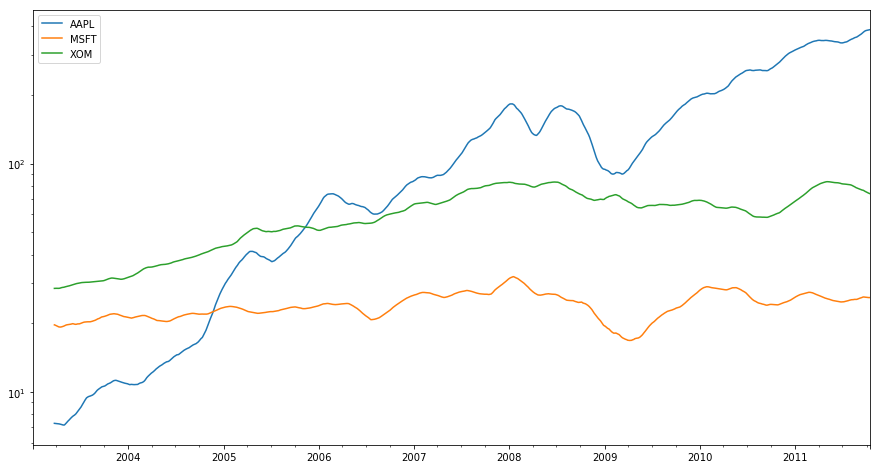

In [27]:
close_px.rolling(60).mean().plot(logy=True, figsize=(15, 8))

rolling函数也接收字符串，用来指定一个大小固定的时间偏移量（fixed-size time offset），而不是用一组周期数字（a set number of periods）来表示。使用这种计划对于没有规律的时间序列很有用。同样的字符串也可以传递给resample使用。例如，我们可以计算一个20天的滑动平均（rolling mean）：

> 译者：在运行下面的代码时，出现了报错，发现是pandas版本的问题，运行`conda update numpy`会把包括numpy，pandas之类的很多库进行更新，之后就不会报错了

In [10]:
rolling_mean = close_px.rolling('20D').mean()
print(rolling_mean.head())
print(rolling_mean.tail())

                AAPL       MSFT        XOM
2003-01-02  7.400000  21.110000  29.220000
2003-01-03  7.425000  21.125000  29.230000
2003-01-06  7.433333  21.256667  29.473333
2003-01-07  7.432500  21.425000  29.342500
2003-01-08  7.402000  21.402000  29.240000
                  AAPL       MSFT        XOM
2011-10-10  389.351429  25.602143  72.527857
2011-10-11  388.505000  25.674286  72.835000
2011-10-12  388.531429  25.810000  73.400714
2011-10-13  388.826429  25.961429  73.905000
2011-10-14  391.038000  26.048667  74.185333


# 1 Exponentially Weighted Functions（指数权重函数）

另一个用相同权重计算固定窗口大小的方法是指定一个常数衰减因子（constant decay factor），把更多的权重给最近观测到的数据上。有很多方法可以指定衰减引子，一种方法是用span，生成的结果与滑动窗口函数是有可比性的，当然，窗口大小与span的大小要一致。

因为一个指数权重统计方法会把更大的权重基于最近观测到的数据上，这种方法带来的变化比平均权重方法要快很多。

pandas有一个ewm操作符，可以与rolling和expanding一起使用。这里有一个例子，在设置EW移动平均（moving average）为span=60的情况下，比较苹果股价的60天移动平均：

In [11]:
aapl_px = close_px.AAPL['2006':'2007']

In [12]:
ma60 = aapl_px.rolling(30, min_periods=20).mean()

In [13]:
ewma60 = aapl_px.ewm(span=30).mean()

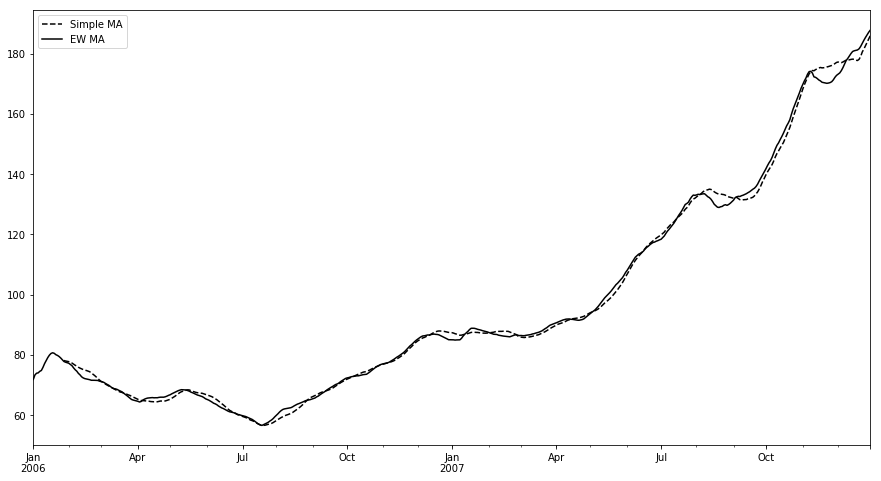

In [26]:
ma60.plot(style='k--', label='Simple MA', figsize=(15, 8))
ewma60.plot(style='k-', label='EW MA', figsize=(15, 8))
plt.legend()

# 2 Binary Moving Window Functions（二元移动窗口函数）

一些统计计算符，比如相关性和协方差，需要在两个时间序列上进行计算。例如，经济分析通常喜欢比较一只股票与基础指数标普500之间的相关性。我们先计算一下时间序列的百分比变化：

In [15]:
spx_px = close_px_all['SPX']

In [16]:
spx_rets = spx_px.pct_change()

In [17]:
returns = close_px.pct_change()

在我们调用rolling后，corr聚合函数会去计算spx_rets的滚动相关性（rolling correlation）：

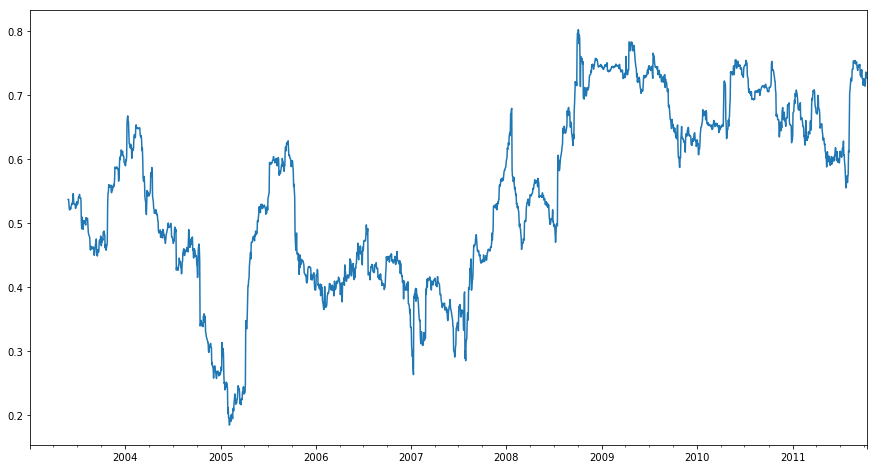

In [24]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot(figsize=(15, 8))

假设我们想要一次计算很多股票与标普500指数的相关性。写一个循环，创建一个新的DataFrame虽然简单但是重复性高，所以我们可以传入一个Series和DataFrame，然后用rolling_corr这样的函数来计算每一列与Series的相关性（在这里例子里，Series指的是spx_rets）：

In [19]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)

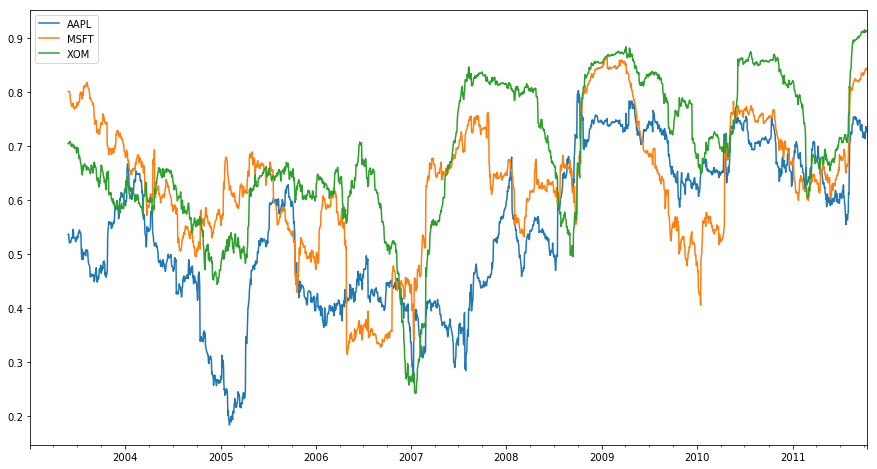

In [23]:
corr.plot(figsize=(15, 8))

# 3 User-Defined Moving Window Functions（用户自定义的移动窗口函数）

在rolling上使用apply或其他一些方法，可以在自己设计的移动窗口上应用函数。唯一需要满足的是，在数组的每一个片段上，函数必须产生单个值。例如，如我们想要用`rolling(...).quantile(q)`计算样本分位数，我们可能对于某个特定值的分位数排名感兴趣。scipy.stats.percentileofscore函数就是用来做这个的：

In [31]:
from scipy.stats import percentileofscore

In [32]:
score_at_2percent = lambda x: percentileofscore(x, 0.02)

In [33]:
result = returns.AAPL.rolling(250).apply(score_at_2percent)

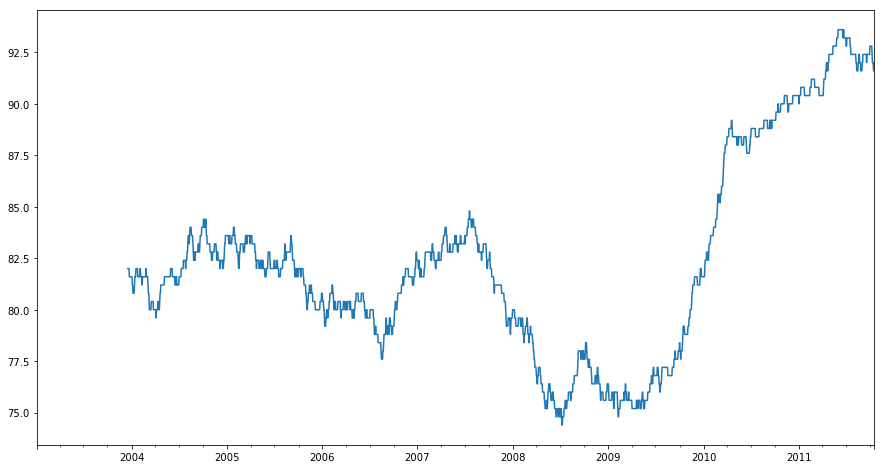

In [36]:
result.plot(figsize=(15, 8))